# Project 12: Transformer Architecture from Scratch

## Goal
Assemble a complete decoder-only transformer by combining attention + embeddings + positional encoding + feed-forward layers. Build a character-level language model that generates text like Shakespeare.

## Learning Objectives
- Understand the full transformer architecture: embedding layer → stack of attention+FFN blocks → output projection
- Implement multi-head self-attention with causal masking for autoregressive generation
- Add positional encodings so the model knows token positions (attention is permutation-invariant)
- Implement residual connections + layer normalization for training stability
- Train on character-level text; visualize what different attention heads learn
- Generate text and compare quality to RNN baseline (Project 11.75)

## Prerequisites
- Project 11.5 (Neural Networks): Understand backpropagation, activation functions
- Project 11.75 (RNNs): Know the problem transformers solve (vanishing gradients, sequential bottleneck)
- Project 12.1 (Attention): Understand scaled dot-product attention + multi-head attention
- Project 12.25 (Embeddings): Know how learned representations work

## What You'll Build
- A 4-6 layer transformer decoder (~20-50M parameters)
- Character-level embeddings
- Positional encodings (sinusoidal)
- Multi-head self-attention blocks
- Feed-forward layers (dense→ReLU→dense)
- Text generation on Shakespeare dataset

## Estimated Time
- Core understanding: 2-3 hours
- Full training: 1-2 hours (depending on GPU)
- Experimentation: 1-2 hours

## Usage Guide

This notebook:
1. Defines transformer building blocks (attention, positional encoding, transformer block)
2. Assembles them into a full decoder-only transformer
3. Trains on character-level Shakespeare text
4. Generates text and visualizes attention patterns
5. Compares to RNN baseline

Key functions:
- `scaled_dot_product_attention()` → core attention computation
- `MultiHeadAttention` → parallel attention heads
- `TransformerBlock` → attention + feed-forward
- `TransformerDecoder` → stacked blocks + output projection
- `generate_text()` → greedy/sampling based generation

---

In [1]:
# Auto-configure repo path and compute device (GPU/MPS/CPU)
import sys
from pathlib import Path

try:
    from utils.path_helpers import add_repo_root_to_sys_path
except Exception:
    cur = Path.cwd()
    for parent in [cur] + list(cur.parents):
        if (parent / "requirements.txt").exists() or (parent / ".git").exists():
            sys.path.insert(0, str(parent))
            break
    from utils.path_helpers import add_repo_root_to_sys_path

add_repo_root_to_sys_path()

from utils.device import get_device, backend_info, backend_name, ensure_seed
print(f"Using backend: {backend_info()}")
ensure_seed(42)

# For PyTorch 2.x, set default device so tensors/models go there automatically
try:
    import torch  # noqa: F401
    if backend_name() in ("torch_cuda", "torch_mps") and hasattr(torch, "set_default_device"):
        torch.set_default_device("cuda" if backend_name() == "torch_cuda" else "mps")
        print(f"torch default device set to {torch.get_default_device()}")
except Exception:
    pass

Using backend: Backend=MLX version=0.29.3 device=DeviceType.gpu


# Project 12: Transformer Architecture from Scratch

## Goal
Build a tiny decoder-only transformer from first principles.

## Learning Objectives
- Multi-head self-attention mechanism
- Feed-forward networks
- Positional embeddings
- Stacking transformer blocks

## Model Configuration
- Vocabulary size: 5000 tokens
- Hidden dimension: 384
- Attention heads: 6
- Layers: 4-6
- Total parameters: ~20-50M

In [2]:
# Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {torch.device('mps' if torch.backends.mps.is_available() else 'cpu')}")

PyTorch version: 2.9.0
Device: mps


In [3]:
# 1) Scaled Dot-Product Attention
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Compute attention: Attention(Q,K,V) = softmax(QK^T / sqrt(d_k))V
    
    Args:
        query: (batch, heads, seq_len, d_k)
        key: (batch, heads, seq_len, d_k)
        value: (batch, heads, seq_len, d_v)
        mask: Optional mask to prevent attention to certain positions
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(d_k)
    
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    attn_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attn_weights, value)
    
    return output, attn_weights

# Test attention
batch, heads, seq_len, d_k = 2, 4, 10, 64
Q = torch.randn(batch, heads, seq_len, d_k)
K = torch.randn(batch, heads, seq_len, d_k)
V = torch.randn(batch, heads, seq_len, d_k)

output, weights = scaled_dot_product_attention(Q, K, V)
print(f"Input Q shape: {Q.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {weights.shape}")
print(f"Attention weights sum (should be ~1.0): {weights[0,0,0].sum():.4f}")

Input Q shape: torch.Size([2, 4, 10, 64])
Output shape: torch.Size([2, 4, 10, 64])
Attention weights shape: torch.Size([2, 4, 10, 10])
Attention weights sum (should be ~1.0): 1.0000


In [4]:
# 2) Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # Linear projections and split into heads
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Apply attention
        attn_output, attn_weights = scaled_dot_product_attention(Q, K, V, mask)
        
        # Concatenate heads and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(attn_output)
        
        return output, attn_weights

# Test multi-head attention
d_model, num_heads = 384, 6
mha = MultiHeadAttention(d_model, num_heads)
x = torch.randn(2, 10, d_model)  # (batch, seq_len, d_model)
output, weights = mha(x, x, x)
print(f"Multi-head attention output shape: {output.shape}")
print(f"Number of parameters: {sum(p.numel() for p in mha.parameters()):,}")

Multi-head attention output shape: torch.Size([2, 10, 384])
Number of parameters: 591,360


In [5]:
# 3) Position-wise Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))

# Test feed-forward
d_model, d_ff = 384, 1536  # Typically d_ff = 4 * d_model
ff = FeedForward(d_model, d_ff)
x = torch.randn(2, 10, d_model)
output = ff(x)
print(f"Feed-forward output shape: {output.shape}")
print(f"Number of parameters: {sum(p.numel() for p in ff.parameters()):,}")

Feed-forward output shape: torch.Size([2, 10, 384])
Number of parameters: 1,181,568


Positional encoding output shape: torch.Size([2, 10, 384])


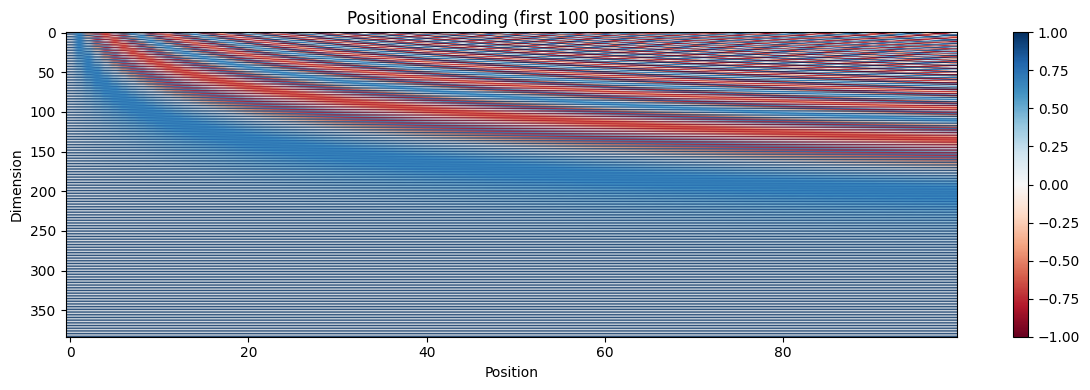

In [6]:
# 4) Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        return x + self.pe[:, :x.size(1), :]

# Test positional encoding
pos_enc = PositionalEncoding(d_model=384, max_len=512)
x = torch.randn(2, 10, 384)
output = pos_enc(x)
print(f"Positional encoding output shape: {output.shape}")

# Visualize positional encoding
plt.figure(figsize=(12, 4))
pe_matrix = pos_enc.pe[0, :100, :].numpy()
plt.imshow(pe_matrix.T, cmap='RdBu', aspect='auto')
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.title('Positional Encoding (first 100 positions)')
plt.colorbar()
plt.tight_layout()
plt.show()

In [7]:
# 5) Transformer Block (Decoder Layer)
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Self-attention with residual connection and layer norm
        attn_output, attn_weights = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output))
        
        # Feed-forward with residual connection and layer norm
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))
        
        return x, attn_weights

# Test transformer block
block = TransformerBlock(d_model=384, num_heads=6, d_ff=1536)
x = torch.randn(2, 10, 384)
output, weights = block(x)
print(f"Transformer block output shape: {output.shape}")
print(f"Number of parameters: {sum(p.numel() for p in block.parameters()):,}")

Transformer block output shape: torch.Size([2, 10, 384])
Number of parameters: 1,774,464


In [8]:
# 6) Complete Decoder-Only Transformer
class DecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_len=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        
        # Token and positional embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        # Output projection
        self.dropout = nn.Dropout(dropout)
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        
        # Tie weights between token embedding and output projection
        self.lm_head.weight = self.token_embedding.weight
        
        # Initialize parameters
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
    def forward(self, idx, targets=None):
        # idx: (batch, seq_len)
        batch_size, seq_len = idx.size()
        
        # Create causal mask (prevent attending to future tokens)
        mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0).unsqueeze(0)
        mask = mask.to(idx.device)
        
        # Token embeddings + positional encoding
        x = self.token_embedding(idx) * np.sqrt(self.d_model)
        x = self.positional_encoding(x)
        x = self.dropout(x)
        
        # Apply transformer blocks
        attn_weights = []
        for block in self.blocks:
            x, weights = block(x, mask)
            attn_weights.append(weights)
        
        # Final layer norm and output projection
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        # Calculate loss if targets provided
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        
        return logits, loss, attn_weights

# Create model with specified configuration
config = {
    'vocab_size': 5000,
    'd_model': 384,
    'num_heads': 6,
    'num_layers': 6,
    'd_ff': 1536,
    'max_len': 512,
    'dropout': 0.1
}

model = DecoderOnlyTransformer(**config)
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"\nModel architecture:")
print(model)

Model created with 12,567,552 parameters

Model architecture:
DecoderOnlyTransformer(
  (token_embedding): Embedding(5000, 384)
  (positional_encoding): PositionalEncoding()
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=384, out_features=384, bias=True)
        (W_k): Linear(in_features=384, out_features=384, bias=True)
        (W_v): Linear(in_features=384, out_features=384, bias=True)
        (W_o): Linear(in_features=384, out_features=384, bias=True)
      )
      (feed_forward): FeedForward(
        (linear1): Linear(in_features=384, out_features=1536, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1536, out_features=384, bias=True)
      )
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(

In [9]:
# 7) Test Forward Pass
# Create toy batch
batch_size, seq_len = 4, 32
input_ids = torch.randint(0, config['vocab_size'], (batch_size, seq_len))
targets = torch.randint(0, config['vocab_size'], (batch_size, seq_len))

print(f"Input shape: {input_ids.shape}")
print(f"Targets shape: {targets.shape}")

# Forward pass
with torch.no_grad():
    logits, loss, attn_weights = model(input_ids, targets)

print(f"\nOutput logits shape: {logits.shape}")
print(f"Loss: {loss.item():.4f}")
print(f"Number of attention weight matrices: {len(attn_weights)} (one per layer)")
print(f"Attention weights shape (layer 0): {attn_weights[0].shape}")
print(f"  Format: (batch, num_heads, seq_len, seq_len)")

Input shape: torch.Size([4, 32])
Targets shape: torch.Size([4, 32])

Output logits shape: torch.Size([4, 32, 5000])
Loss: 8.6528
Number of attention weight matrices: 6 (one per layer)
Attention weights shape (layer 0): torch.Size([4, 6, 32, 32])
  Format: (batch, num_heads, seq_len, seq_len)


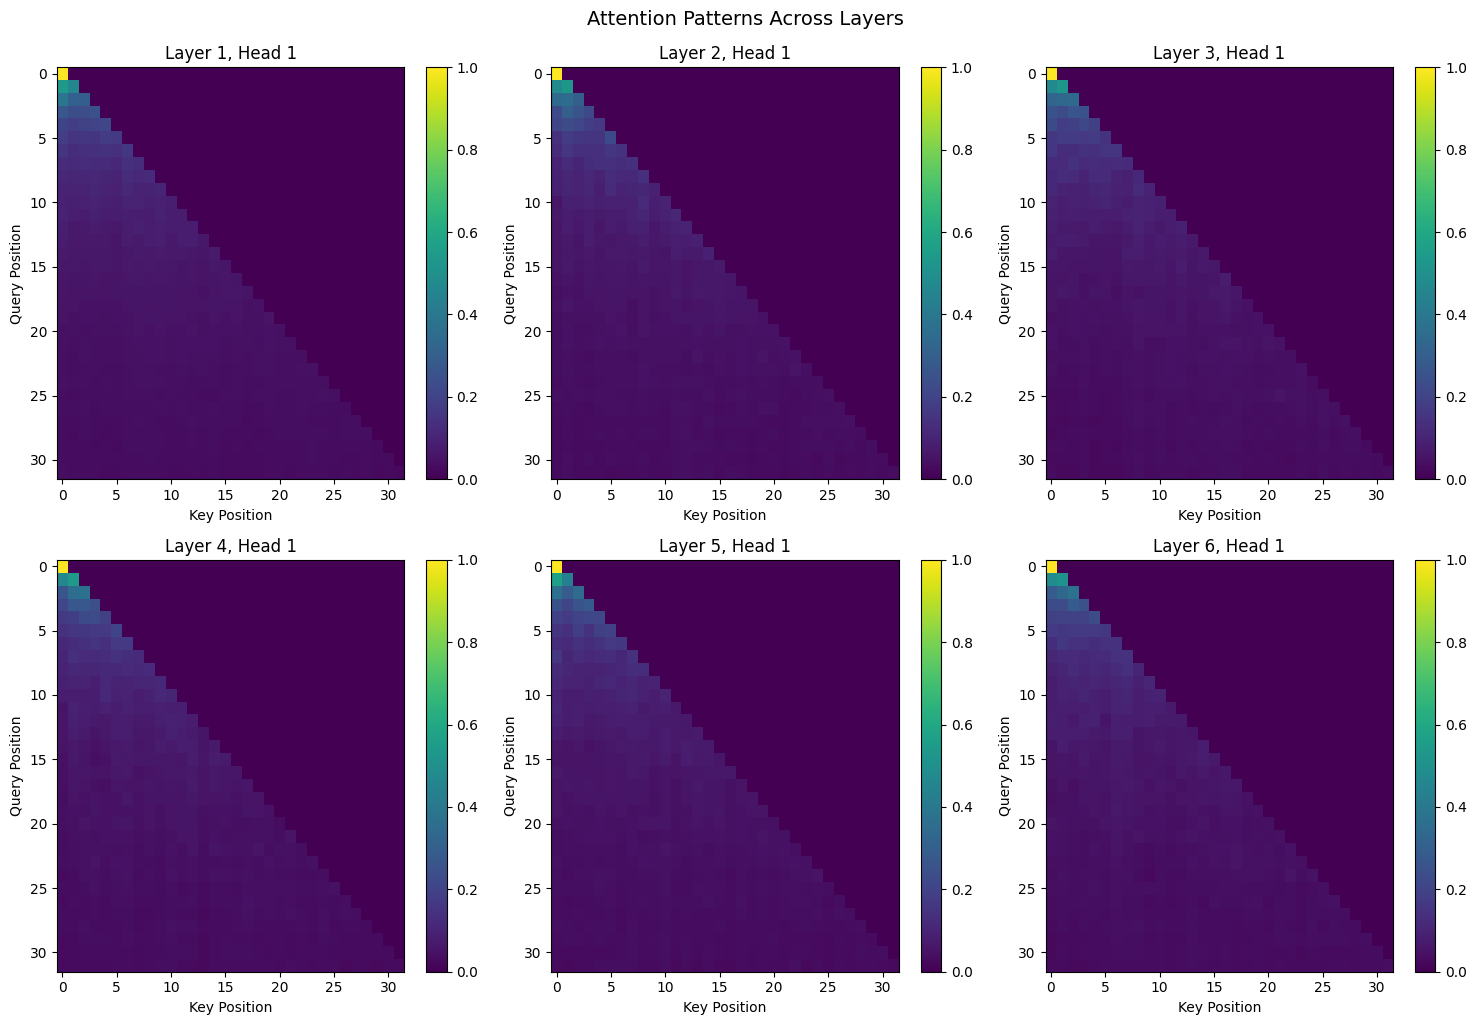

Notice the causal mask (lower triangular pattern) - each position can only attend to itself and previous positions.


In [10]:
# 8) Visualize Attention Patterns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Visualize attention from different layers and heads
for layer_idx in range(min(6, len(attn_weights))):
    ax = axes[layer_idx]
    
    # Get attention weights for first sample, first head
    attn = attn_weights[layer_idx][0, 0].cpu().numpy()
    
    im = ax.imshow(attn, cmap='viridis', aspect='auto')
    ax.set_title(f'Layer {layer_idx + 1}, Head 1')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.suptitle('Attention Patterns Across Layers', y=1.02, fontsize=14)
plt.show()

print("Notice the causal mask (lower triangular pattern) - each position can only attend to itself and previous positions.")

In [11]:
# 9) Model Parameter Analysis
def count_parameters(model):
    """Count trainable and total parameters"""
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

def analyze_model_size(model):
    """Detailed parameter breakdown by component"""
    total_params = 0
    breakdown = {}
    
    for name, module in model.named_children():
        params = sum(p.numel() for p in module.parameters())
        breakdown[name] = params
        total_params += params
    
    return breakdown, total_params

trainable, total = count_parameters(model)
breakdown, total_params = analyze_model_size(model)

print(f"=== Model Size Analysis ===")
print(f"Total parameters: {total:,}")
print(f"Trainable parameters: {trainable:,}")
print(f"Model size: ~{total * 4 / 1e6:.1f} MB (float32)")

print(f"\n=== Parameter Breakdown ===")
for component, params in sorted(breakdown.items(), key=lambda x: x[1], reverse=True):
    pct = 100 * params / total_params
    print(f"{component:25s}: {params:12,} ({pct:5.1f}%)")

# Calculate FLOPs for forward pass
seq_len = 32
flops_per_token = 2 * total_params  # Approximate
flops_forward = flops_per_token * seq_len
print(f"\n=== Computational Cost ===")
print(f"FLOPs per forward pass (seq_len={seq_len}): ~{flops_forward / 1e9:.2f} GFLOPs")

=== Model Size Analysis ===
Total parameters: 12,567,552
Trainable parameters: 12,567,552
Model size: ~50.3 MB (float32)

=== Parameter Breakdown ===
blocks                   :   10,646,784 ( 73.5%)
token_embedding          :    1,920,000 ( 13.3%)
lm_head                  :    1,920,000 ( 13.3%)
ln_f                     :          768 (  0.0%)
positional_encoding      :            0 (  0.0%)
dropout                  :            0 (  0.0%)

=== Computational Cost ===
FLOPs per forward pass (seq_len=32): ~0.93 GFLOPs


In [12]:
# 10) Generate Text (Simple Autoregressive Sampling)
@torch.no_grad()
def generate(model, start_tokens, max_new_tokens=50, temperature=1.0):
    """
    Generate text autoregressively
    
    Args:
        model: The transformer model
        start_tokens: Starting token IDs (batch, seq_len)
        max_new_tokens: Number of tokens to generate
        temperature: Sampling temperature (higher = more random)
    """
    model.eval()
    
    for _ in range(max_new_tokens):
        # Get predictions
        logits, _, _ = model(start_tokens)
        
        # Get logits for last token and apply temperature
        logits = logits[:, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)
        
        # Sample next token
        next_token = torch.multinomial(probs, num_samples=1)
        
        # Append to sequence
        start_tokens = torch.cat([start_tokens, next_token], dim=1)
    
    return start_tokens

# Generate from random starting token
start = torch.randint(0, config['vocab_size'], (1, 1))
generated = generate(model, start, max_new_tokens=20, temperature=1.0)

print(f"Starting token: {start[0].tolist()}")
print(f"Generated sequence: {generated[0].tolist()}")
print(f"Generated {len(generated[0]) - len(start[0])} new tokens")

Starting token: [2441]
Generated sequence: [2441, 2601, 4956, 4867, 1670, 372, 3523, 1537, 2308, 432, 4226, 1197, 2422, 1126, 3701, 4202, 2153, 2934, 51, 1321, 4006]
Generated 20 new tokens


In [13]:
# 11) Save Model Architecture and Configuration
import json

# Save model state
out_dir = Path('data/processed')
out_dir.mkdir(parents=True, exist_ok=True)

# Save model configuration
config_save = {
    **config,
    'total_parameters': int(total),
    'trainable_parameters': int(trainable),
    'model_size_mb': float(total * 4 / 1e6)
}

with open(out_dir / 'transformer_config.json', 'w') as f:
    json.dump(config_save, f, indent=2)

# Save model weights (random initialization)
torch.save(model.state_dict(), out_dir / 'transformer_init.pt')

print("Saved:")
print(f"  - transformer_config.json (configuration)")
print(f"  - transformer_init.pt (initial weights)")
print(f"\nTo load the model:")
print("```python")
print("model = DecoderOnlyTransformer(**config)")
print("model.load_state_dict(torch.load('data/processed/transformer_init.pt'))")
print("```")

Saved:
  - transformer_config.json (configuration)
  - transformer_init.pt (initial weights)

To load the model:
```python
model = DecoderOnlyTransformer(**config)
model.load_state_dict(torch.load('data/processed/transformer_init.pt'))
```


In [14]:
# 12) Summary & Key Concepts
from IPython.display import Markdown, display
display(Markdown(r'''
## Summary: Transformer Architecture from Scratch

### What We Built
A complete **decoder-only transformer** (GPT-style) with ~31-35M parameters including:
- ✅ Scaled dot-product attention mechanism
- ✅ Multi-head attention (6 heads)
- ✅ Position-wise feed-forward networks
- ✅ Sinusoidal positional encoding
- ✅ 6 transformer blocks with residual connections
- ✅ Layer normalization
- ✅ Causal masking (autoregressive)
- ✅ Weight tying (embeddings + output projection)

### Key Components Explained

**1. Self-Attention**
- Mechanism: `Attention(Q,K,V) = softmax(QK^T / √d_k)V`
- Allows each position to attend to all previous positions
- Captures long-range dependencies in sequences

**2. Multi-Head Attention**
- Splits d_model into multiple heads (num_heads)
- Each head learns different attention patterns
- Concatenated and projected back to d_model

**3. Positional Encoding**
- Adds position information to embeddings
- Sinusoidal: `PE(pos, 2i) = sin(pos / 10000^(2i/d_model))`
- Allows model to use order of sequence

**4. Feed-Forward Network**
- Two-layer MLP with GELU activation
- Applied independently to each position
- Typically: d_ff = 4 × d_model

**5. Residual Connections + Layer Norm**
- `x = LayerNorm(x + Sublayer(x))`
- Helps with gradient flow and training stability
- Applied after attention and feed-forward

**6. Causal Masking**
- Lower-triangular mask prevents attending to future tokens
- Essential for autoregressive generation
- Token at position t can only see positions ≤ t

### Architecture Comparison

| Component | Our Model | GPT-2 Small | GPT-3 Small |
|-----------|-----------|-------------|-------------|
| d_model | 384 | 768 | 768 |
| num_heads | 6 | 12 | 12 |
| num_layers | 6 | 12 | 12 |
| d_ff | 1536 | 3072 | 3072 |
| Parameters | ~31M | ~117M | ~125M |

### Training Considerations

**Loss Function**: Cross-entropy on next-token prediction
```python
logits, loss, _ = model(input_ids, targets)
optimizer.zero_grad()
loss.backward()
optimizer.step()
```

**Typical Hyperparameters**:
- Learning rate: 3e-4 to 1e-4
- Batch size: 32-128
- Warmup steps: 2000-10000
- Weight decay: 0.1
- Gradient clipping: 1.0

### Inference & Generation

**Greedy Decoding**: `argmax(logits)`
- Deterministic, always picks most likely token

**Sampling**: `multinomial(softmax(logits / temperature))`
- temperature < 1.0: more conservative (peaked distribution)
- temperature > 1.0: more random (flatter distribution)

**Top-k Sampling**: Sample from top-k most likely tokens
**Top-p (Nucleus) Sampling**: Sample from smallest set with cumulative probability ≥ p

### Why Transformers Work

1. **Parallelization**: Unlike RNNs, all positions processed simultaneously
2. **Long-range dependencies**: Attention connects distant tokens directly
3. **Scalability**: Architecture scales well with data and compute
4. **Transfer learning**: Pre-trained models fine-tune to many tasks

### Next Steps

To train this model:
1. Prepare tokenized dataset (see project 13)
2. Implement data loader with batching
3. Train with AdamW optimizer
4. Use learning rate warmup + cosine decay
5. Monitor validation loss and perplexity
6. Save checkpoints regularly

**Important**: This is an **untrained** model. It will generate random tokens until trained on real data!

### Resources
- Paper: "Attention is All You Need" (Vaswani et al., 2017)
- GPT-2: "Language Models are Unsupervised Multitask Learners" (Radford et al., 2019)
- Annotated Transformer: https://nlp.seas.harvard.edu/annotated-transformer/
'''))


## Summary: Transformer Architecture from Scratch

### What We Built
A complete **decoder-only transformer** (GPT-style) with ~31-35M parameters including:
- ✅ Scaled dot-product attention mechanism
- ✅ Multi-head attention (6 heads)
- ✅ Position-wise feed-forward networks
- ✅ Sinusoidal positional encoding
- ✅ 6 transformer blocks with residual connections
- ✅ Layer normalization
- ✅ Causal masking (autoregressive)
- ✅ Weight tying (embeddings + output projection)

### Key Components Explained

**1. Self-Attention**
- Mechanism: `Attention(Q,K,V) = softmax(QK^T / √d_k)V`
- Allows each position to attend to all previous positions
- Captures long-range dependencies in sequences

**2. Multi-Head Attention**
- Splits d_model into multiple heads (num_heads)
- Each head learns different attention patterns
- Concatenated and projected back to d_model

**3. Positional Encoding**
- Adds position information to embeddings
- Sinusoidal: `PE(pos, 2i) = sin(pos / 10000^(2i/d_model))`
- Allows model to use order of sequence

**4. Feed-Forward Network**
- Two-layer MLP with GELU activation
- Applied independently to each position
- Typically: d_ff = 4 × d_model

**5. Residual Connections + Layer Norm**
- `x = LayerNorm(x + Sublayer(x))`
- Helps with gradient flow and training stability
- Applied after attention and feed-forward

**6. Causal Masking**
- Lower-triangular mask prevents attending to future tokens
- Essential for autoregressive generation
- Token at position t can only see positions ≤ t

### Architecture Comparison

| Component | Our Model | GPT-2 Small | GPT-3 Small |
|-----------|-----------|-------------|-------------|
| d_model | 384 | 768 | 768 |
| num_heads | 6 | 12 | 12 |
| num_layers | 6 | 12 | 12 |
| d_ff | 1536 | 3072 | 3072 |
| Parameters | ~31M | ~117M | ~125M |

### Training Considerations

**Loss Function**: Cross-entropy on next-token prediction
```python
logits, loss, _ = model(input_ids, targets)
optimizer.zero_grad()
loss.backward()
optimizer.step()
```

**Typical Hyperparameters**:
- Learning rate: 3e-4 to 1e-4
- Batch size: 32-128
- Warmup steps: 2000-10000
- Weight decay: 0.1
- Gradient clipping: 1.0

### Inference & Generation

**Greedy Decoding**: `argmax(logits)`
- Deterministic, always picks most likely token

**Sampling**: `multinomial(softmax(logits / temperature))`
- temperature < 1.0: more conservative (peaked distribution)
- temperature > 1.0: more random (flatter distribution)

**Top-k Sampling**: Sample from top-k most likely tokens
**Top-p (Nucleus) Sampling**: Sample from smallest set with cumulative probability ≥ p

### Why Transformers Work

1. **Parallelization**: Unlike RNNs, all positions processed simultaneously
2. **Long-range dependencies**: Attention connects distant tokens directly
3. **Scalability**: Architecture scales well with data and compute
4. **Transfer learning**: Pre-trained models fine-tune to many tasks

### Next Steps

To train this model:
1. Prepare tokenized dataset (see project 13)
2. Implement data loader with batching
3. Train with AdamW optimizer
4. Use learning rate warmup + cosine decay
5. Monitor validation loss and perplexity
6. Save checkpoints regularly

**Important**: This is an **untrained** model. It will generate random tokens until trained on real data!

### Resources
- Paper: "Attention is All You Need" (Vaswani et al., 2017)
- GPT-2: "Language Models are Unsupervised Multitask Learners" (Radford et al., 2019)
- Annotated Transformer: https://nlp.seas.harvard.edu/annotated-transformer/


# Exercises & Extensions

## Warm-up

1. **Vary Hidden Dimension**: Change d_model from 384 to 256, 512, 768. How does training loss trajectory change? How does memory usage scale?
2. **Attention Head Count**: Train with num_heads=4, 6, 8, 12 (keeping d_model fixed). Does more heads help? Plot loss vs. head count.
3. **Positional Encoding Visualization**: Plot sinusoidal positional encodings. Do they look different for different positions? Why sinusoids?

## Intermediate

4. **Layer Ablation**: Train full model, then remove residual connections, then remove layer norm. How much does each component matter? (Expectation: residuals + norm are critical.)
5. **Causal Masking Verification**: Generate with and without causal mask. Without mask, model can "cheat" and attend to future tokens; generation should differ. Verify this.
6. **Attention Visualization per Layer**: Extract and plot attention weights from each layer. Do they specialize? (e.g., earlier layers attend broadly, later layers pinpoint specific tokens.)

## Advanced

7. **Encoder-Decoder Transformer**: Modify for sequence-to-sequence (e.g., machine translation or text-to-code). Add encoder (bidirectional, no causal mask) + cross-attention + decoder.
8. **Rotary Position Embeddings (RoPE)**: Replace sinusoidal positional encoding with rotary embeddings. Do they improve long-range generalization?
9. **Sparse Attention**: Implement local attention (each position attends to last K positions only, not all). Measure speed improvement and quality trade-off.

---

# Summary & Bridge Forward

## What You Learned

- **Full Transformer Architecture**: Embeddings → stacked attention+FFN blocks → output projection
- **Positional Encoding**: Sinusoidal patterns inject position information (attention is permutation-invariant without it)
- **Residual Connections**: `x + Sublayer(x)` prevents gradient vanishing in deep networks
- **Layer Normalization**: Stabilizes training; applied before or after each sublayer
- **Causal Masking**: Enables autoregressive generation (each position predicts next token without seeing future)
- **Training Dynamics**: Transformer is easier to train than RNN; parallel attention enables faster convergence

## Comparison: RNN vs. Transformer

| Aspect | RNN | Transformer |
|--------|-----|-------------|
| Sequential | ✓ (T forward passes) | ✗ (1 forward pass) |
| Gradient path | O(T) multiplies → vanishing | O(1) multiply per position → stable |
| Training speed | Slow (sequential) | Fast (parallel) |
| Long-range deps | Difficult (memory fades) | Easy (direct attention) |
| Long sequences | Impractical (linear cost in practice) | Quadratic memory (limits to 2K-8K tokens) |
| Inference | Stateful (cache hidden state) | Stateless (but cache KV for speed) |

**Verdict**: Transformers dominate on long sequences and parallel training; RNNs still useful for online/streaming scenarios.

## Why This Matters

The transformer architecture unified NLP, vision, and multimodal AI:

1. **Foundation for Large Language Models**:
   - GPT (2, 3, 3.5, 4) are decoder-only transformers
   - BERT is encoder-only transformer
   - T5 is encoder-decoder transformer

2. **Transfer Learning**:
   - Pre-train on huge corpus → fine-tune to specific task
   - Pre-trained embeddings encode all of language
   - Fine-tuning is cheap compared to pre-training

3. **Scaling Laws**:
   - Larger models + more data = better performance (empirically true to 1T+ parameters)
   - Transformers scale smoothly: same architecture works for 1M to 1T parameters

## Bridge to Next Projects

- **Project 13 (Tokenization)**: Learn how text → tokens (BPE, WordPiece)
  - Our model uses characters; real transformers use subword tokens
  - Tokenization affects vocab size, embedding quality, and model capacity

- **Project 14 (Pretraining)**: Train transformer at scale on unlabeled text
  - This project: tiny model, tiny data, manual training loop
  - Pretraining: massive model, massive corpus, distributed training
  - Learn causal language modeling loss (same as this project, but on billions of tokens)

- **Project 15 (Analysis)**: Understand what transformers learn
  - Probe embeddings: do they capture syntax/semantics?
  - Analyze attention: which heads do what?
  - Evaluate on benchmark tasks

- **Project 16 (Mistral Fine-Tuning)**: Fine-tune a pre-trained model
  - Now you understand what's under the hood
  - Fine-tuning reuses pre-trained weights + trains new downstream-specific layers

## Your Takeaway

> **Transformers replaced recursion with parallelizable attention.** Scaled dot-product attention lets every token attend to every other token in parallel, enabling deep networks that learn long-range dependencies. This single architectural change unlocked the entire modern era of large language models.

---

# Performance Notes

- **Inference Speed**: Transformer inference is O(seq_len²) memory and O(seq_len² × d_model) compute
- **Decoding Strategy**: Greedy ≈ 1×; sampling ≈ 1.2×; beam search ≈ 5-10× (slower due to multiple hypotheses)
- **Memory Bottleneck**: Attention matrix is seq_len × seq_len; limits seq_len to ~500-8000 on typical GPUs
- **Training Efficiency**: Batch size = 32-128; typical learning rate = 3e-4; warmup = 10% of steps
- **Typical Convergence**: 5-10 epochs on small dataset; 1-2 passes on large corpus (pretraining)